# ResNet from scratch

As I don't understand how to implement a precoded resnet an encoder, here I will write my own resnet from scratch to get a feeling and understanding for it.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data_scclevr import makeRings 
from model import InvariantSlotAttention

from matplotlib.patches import Circle
import json

# Set numpy seed for test set sampling 
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from plotting import plot_chosen_slots, plot_kslots, plot_kslots_iters, plot_kslots_grads

from torch.nn import init
import scclevr
import torch.nn as nn
import torchvision.models as models

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'
cID_prev = 'isa-alpha3_scclevr'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [6]:
def _convert_into_pytorch_tensors(event_images, object_images, n_objects, object_features, device):
    return torch.FloatTensor(event_images).to(device), \
               torch.FloatTensor(object_images).to(device), \
               torch.FloatTensor(n_objects).to(device), \
               torch.FloatTensor(object_features).to(device)

In [5]:
def hungarian_matching(pairwise_cost):
    '''
    Input:
    - pairwise_cost


    Hungarian section Translated from the TensorFlow loss function (from 2006.15055 code):
    https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
    '''
    
    indices = list(map(linear_sum_assignment, pairwise_cost.cpu()))
    indices = torch.LongTensor(np.array(indices))
    
    loss = 0
    for pi,(ri,ci) in zip(pairwise_cost,indices):
        loss += pi[ri,ci].sum()
    
    return indices 

In [53]:
class BasicBlock(nn.Module):
    """Basic Residual Block"""
    def __init__(self, inplanes, outplanes, stride=1, kernel_size=3, padding=0):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, outplanes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(outplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(outplanes, outplanes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(outplanes)
        
        self.sampling = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, bias=False)
        self.stride = stride
        
        
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        print("identity: ", x.shape)
        print("out: ", out.shape)
        if(identity.shape!=out.shape):
            identity = self.sampling(x)
            
        out += identity # this is the trick!!
        out = self.relu(out)

        return out
    


class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 8,kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        # I choose my conv layers in a way that the final output will be [32, 32] still
        
        # FIRST STAGE -  capture basic features and patterns in the input while reducing its spatial resolution (second not needed?)
        self.layer1 = BasicBlock(8, 8,kernel_size=5, stride=1, padding=2)
        # SECOND STAGE - capture more complex features and patterns compared to the initial stage. The spatial dimensions are reduced, but the number of channels (depth) is increased.
        self.layer2 = BasicBlock(8, 16, kernel_size=3, stride=1, padding=1)
        # THIRD STAGE -  capture more abstract features and high-level representations, as the spatial dimensions continue to decrease.
        self.layer3 = BasicBlock(16, 32, kernel_size=3, stride=1, padding=1)
        # FOUTH STAGE- - capture very abstract and global features, consolidating the information learned from the previous stages.
        self.layer4 = BasicBlock(32, 16, kernel_size=3, stride=1, padding=1)
        
        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #x = self.avgpool(x)
        print("shape after resnet block: ", x.shape)
        return x


In [54]:
class InvariantSlotAttention_ResNet(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 xlow=-0.5,
                 xhigh=0.5,
                 varlow=0.01,
                 varhigh=0.05,
                 k_slots=3, 
                 num_conv_layers=3,
                 which_encoder='ResNet',
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 pixel_mult=1,
                 device='cpu' ,
                 learn_slot_feat=True
                 ):
        '''
        Slot attention encoder block, block attention
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.resolution = resolution
        self.xlow, self.xhigh = xlow, xhigh
        self.rlow, self.rhigh = np.sqrt(varlow), np.sqrt(varhigh)
        
        self.device=device
         
        self.softmax_T = 1/np.sqrt(query_dim)
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)
        
        '''
        CNN feature extractor
        '''
        kwargs = {'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }
        cnn_layers = [torch.nn.Conv2d(1,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
        cnn_layers.append(torch.nn.ReLU())
          
        self.CNN_encoder = torch.nn.Sequential(*cnn_layers) # 3 CNN layers by default
        if which_encoder=='ResNet':
            self.CNN_encoder = ResNet()

            
          
            
        # Grid + query init
        self.abs_grid = self.build_grid()
                   
        self.dense = torch.nn.Linear(2, query_dim) 
        self.pixel_mult = pixel_mult # LH's proposal... but almost same as 1/delta in ISA

        # Apply after the data normalization
        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(query_dim,query_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(query_dim,query_dim)
        )
            
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
        init.xavier_uniform_(self.slots_logsigma)

        self.init_slots = self.init_slots

        
        '''
        Option to add a final (x,y,r) prediction to each slot
        '''
        self.learn_slot_feat = learn_slot_feat
        if self.learn_slot_feat:
            self.final_mlp = torch.nn.Sequential(
                torch.nn.Linear(query_dim,hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, 3)
            )
        
    def build_grid(self):
        '''
        From google slot attention repo:
        https://github.com/nhartman94/google-research/blob/master/slot_attention/model.py#L357C1-L364C53
        '''
        resolution = self.resolution
        xlow, xhigh = self.xlow, self.xhigh
           
        ranges = [np.linspace(xlow, xhigh, num=res) for res in resolution]
        grid = np.meshgrid(*ranges, sparse=False, indexing="xy")
        grid = np.stack(grid, axis=-1)
        grid = np.reshape(grid, [resolution[0], resolution[1], -1])
        grid = np.expand_dims(grid, axis=0)
        
        grid = torch.FloatTensor( grid ).to(self.device)
        grid = torch.flatten(grid,1,2)
    
        return grid
                
    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        
        stdhigh, stdlow = self.rlow, self.rhigh
        
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)
    
        queries = mu + sigma * torch.randn(mu.shape,device=self.device)
    
        # Add the position and scale initialization for the local ref frame
        ref_frame_dim = 3
        pos_scale = torch.rand(Nbatch, self.k_slots, ref_frame_dim,device=self.device)

        pos_scale[:,:2] -= 0.5
        pos_scale[:,-1]  = (stdhigh - stdlow) * pos_scale[:,-1] + stdlow
        
        return queries, pos_scale
     
    def get_keys_vals(self, encoded_data, pos_scale):

        # Get the relative position embedding
        rel_grid = self.abs_grid.unsqueeze(1) - pos_scale[:,:,:2].unsqueeze(2)
        rel_grid /= pos_scale[:,:,-1].unsqueeze(2).unsqueeze(-1)
        
        # Embed it in the same space as the query dimension 
        embed_grid = self.pixel_mult * self.dense( rel_grid )
        
        # keys, vals: (bs, img_dim, query_dim)
        keys = self.toK(encoded_data).unsqueeze(1) + embed_grid
        vals = self.toV(encoded_data).unsqueeze(1) + embed_grid
        
        keys = self.init_mlp(self.queryN(keys))
        vals = self.init_mlp(self.queryN(vals))
        
        return keys, vals
                
    def attention_and_weights(self,queries,keys):
        
        logits = torch.einsum('bse,bsde->bsd',queries,keys) * self.softmax_T
        
        att = torch.nn.functional.softmax(logits, dim = 1)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def update_frames(self,wts):
        '''
        Update the relative frame position
        '''
        
        # expand to include the batch dim
        grid_exp = self.abs_grid.expand(wts.shape[0],-1,2)
        
        new_pos = torch.einsum('bsd,bde->bse',wts,grid_exp)
        
        new_scale = torch.sum(torch.pow(grid_exp.unsqueeze(1) - new_pos.unsqueeze(2),2),dim=-1)
        
        new_scale = torch.einsum('bsd,bsd->bs', wts, new_scale)
        new_scale = torch.sqrt(new_scale)
        
        return torch.cat([new_pos,new_scale.unsqueeze(-1)],axis=-1)
        
    def iterate(self, queries, pos_scale, encoded_data):
        
        # Get the keys and values in the ref ref frame
        keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        
        # att,wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(self.queryN(queries),keys)   
        
        new_pos_scale = self.update_frames(wts)
        
        # Update the queries with the recurrent block
        updates = torch.einsum('bsd,bsde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )
        
        return updates.reshape(queries.shape), new_pos_scale
        
    def forward(self, data):
    
        '''
        Step 1: Extract the CNN features
        '''
        print('data shape', data.shape)
        encoded_data = self.CNN_encoder(data) # Apply the CNN encoder
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) # Put channel dim at the end
        encoded_data = torch.flatten(encoded_data,1,2) # flatten pixel dims
        encoded_data = self.dataN(encoded_data)
        
        '''
        Step 2: Initialize the slots
        '''
        Nbatch = data.shape[0]
        queries, pos_scale = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
                
        '''
        Step 3: Iterate through the reconstruction
        '''
        for i in range(self.n_iter):
            queries, pos_scale = self.iterate(queries, pos_scale, encoded_data)    
            
        # With the final query vector, calc the attn, weights, + rel ref frames
        keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        att, wts = self.attention_and_weights(self.queryN(queries),keys)   
        new_pos_scale = self.update_frames(wts)
                
        if self.learn_slot_feat:
            slot_feat = self.final_mlp(queries)
            
            # Want to learn the delta from the previously estimated position
            slot_feat += new_pos_scale
            
            return queries, att, slot_feat 
        
        else:
            return queries, att, wts

In [55]:
model = InvariantSlotAttention_ResNet(**hps).to(device)

In [56]:
Ntrain = 5000 
bs=32 
lr=3e-4
warmup_steps=5_000
alpha=1
losses = {'tot':[],'bce':[],'mse':[]}
kwargs={'isRing': True, 'N_clusters':2}
clip_val = 1
device='cpu'
plot_every=20 
save_every=1000
color='C0'
cmap='Blues'

# Learning rate schedule config
base_learning_rate = lr

opt = torch.optim.Adam(model.parameters(), base_learning_rate)
model.train()

k_slots = model.k_slots
max_n_rings = kwargs['N_clusters']
resolution = model.resolution
kwargs['device'] = device
N_obj = kwargs['N_clusters'] # pass to makeRing fct

data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16, 32, 32])
out:  torch.Size([32, 32, 32, 32])
identity:  torch.Size([32, 32, 32, 32])
out:  torch.Size([32, 16, 32, 32])
shape after resnet block:  torch.Size([32, 16, 32, 32])
data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16, 32, 32])
out:  torch.Size([32, 32, 32, 32])
identity:  torch.Size([32, 32, 32, 32])
out:  torch.Size([32, 16, 32, 32])
shape after resnet block:  torch.Size([32, 16, 32, 32])
data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16,

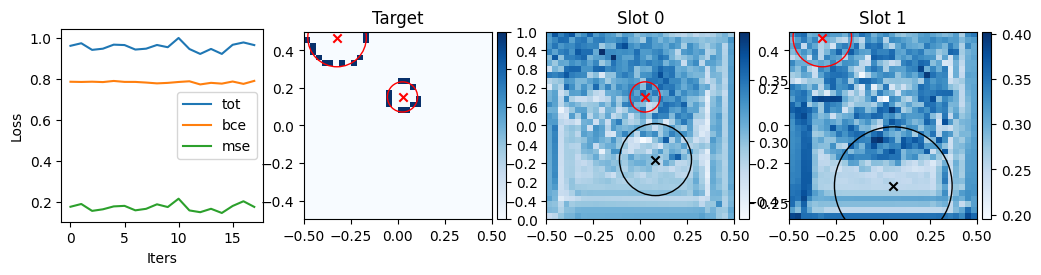

data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16, 32, 32])
out:  torch.Size([32, 32, 32, 32])
identity:  torch.Size([32, 32, 32, 32])
out:  torch.Size([32, 16, 32, 32])
shape after resnet block:  torch.Size([32, 16, 32, 32])
data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16, 32, 32])
out:  torch.Size([32, 32, 32, 32])
identity:  torch.Size([32, 32, 32, 32])
out:  torch.Size([32, 16, 32, 32])
shape after resnet block:  torch.Size([32, 16, 32, 32])
data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16,

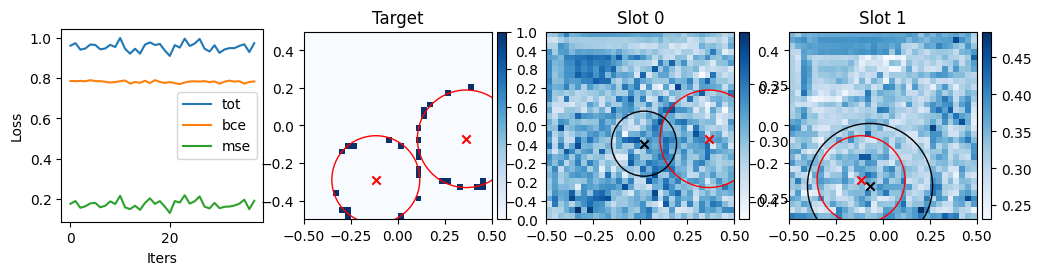

data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16, 32, 32])
out:  torch.Size([32, 32, 32, 32])
identity:  torch.Size([32, 32, 32, 32])
out:  torch.Size([32, 16, 32, 32])
shape after resnet block:  torch.Size([32, 16, 32, 32])
data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16, 32, 32])
out:  torch.Size([32, 32, 32, 32])
identity:  torch.Size([32, 32, 32, 32])
out:  torch.Size([32, 16, 32, 32])
shape after resnet block:  torch.Size([32, 16, 32, 32])
data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16,

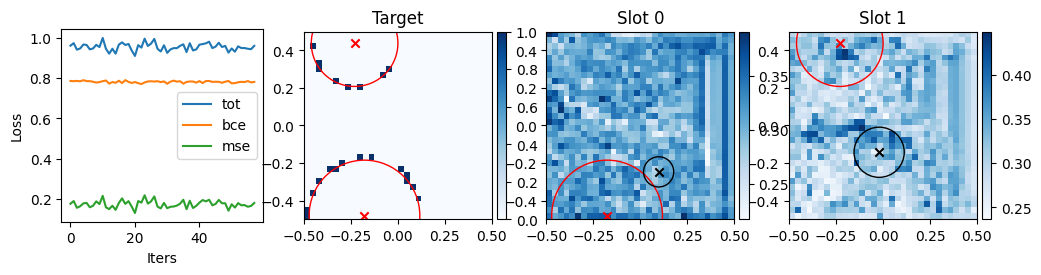

data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16, 32, 32])
out:  torch.Size([32, 32, 32, 32])
identity:  torch.Size([32, 32, 32, 32])
out:  torch.Size([32, 16, 32, 32])
shape after resnet block:  torch.Size([32, 16, 32, 32])
data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16, 32, 32])
out:  torch.Size([32, 32, 32, 32])
identity:  torch.Size([32, 32, 32, 32])
out:  torch.Size([32, 16, 32, 32])
shape after resnet block:  torch.Size([32, 16, 32, 32])
data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16,

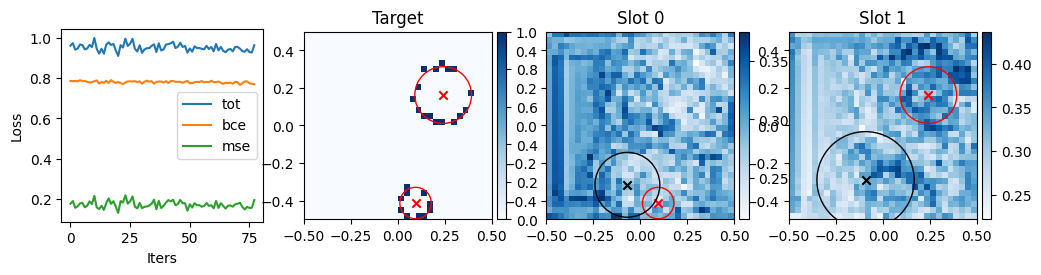

data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16, 32, 32])
out:  torch.Size([32, 32, 32, 32])
identity:  torch.Size([32, 32, 32, 32])
out:  torch.Size([32, 16, 32, 32])
shape after resnet block:  torch.Size([32, 16, 32, 32])
data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16, 32, 32])
out:  torch.Size([32, 32, 32, 32])
identity:  torch.Size([32, 32, 32, 32])
out:  torch.Size([32, 16, 32, 32])
shape after resnet block:  torch.Size([32, 16, 32, 32])
data shape torch.Size([32, 1, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 8, 32, 32])
identity:  torch.Size([32, 8, 32, 32])
out:  torch.Size([32, 16, 32, 32])
identity:  torch.Size([32, 16,

KeyboardInterrupt: 

In [57]:


start = len(losses)
for i in range(start,start+Ntrain):

    learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
    if i < warmup_steps:
        learning_rate *= (i / warmup_steps)
    
    opt.param_groups[0]['lr'] = learning_rate
    
    # make scclevr data
    rings = scclevr.RingsBinaryUniform(N_obj) # two rings per imagne
    event_images, object_images, n_objects, object_features =  rings.gen_events(bs)
    event_images, object_images, n_objects, object_features =  _convert_into_pytorch_tensors(event_images, object_images, n_objects, object_features, device)
    # assign shorter names
    X = event_images
    mask = object_images
    Y = object_features
    
    queries, att, Y_pred = model(X)
        
    # Reshape the target mask to be flat in the pixels (same shape as att)
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))   
    with torch.no_grad():
        
        att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
        mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 
        
        pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
        
        # pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
        indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)
    # Loss calc
    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()
    
    Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()

    # Calculate the loss
    li = l_bce + alpha*l_mse
    
    li.backward()
    clip_val=1
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
    
    opt.step()
    opt.zero_grad()

    losses['tot'].append(float(li))
    losses['bce'].append(float(l_bce))
    losses['mse'].append(float(l_mse))
    
    if i % plot_every == 0:
        print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])  
        iEvt = 0

        # losses, mask, att_img, Y_true, Y_pred
        plot_chosen_slots(losses,
                            mask[iEvt].sum(axis=0), 
                            slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                            Y_true_sorted[iEvt],
                            Y_pred_sorted[iEvt])
        


